# 📈 Exponential Smoothing Analysis

Dieses Notebook analysiert das Exponential Smoothing Modell auf GW2-Preisdaten.

**Exponential Smoothing Varianten:**
- **Simple ES** (ETS(A,N,N)): Keine Trend, keine Saisonalität
- **Holt** (ETS(A,A,N)): Mit Trend
- **Damped Holt** (ETS(A,Ad,N)): Gedämpfter Trend
- **Holt-Winters** (ETS(A,A,A)): Mit Trend und Saisonalität

**Inhalt:**
1. Daten laden und visualisieren
2. Train/Test Split
3. Modell trainieren & vergleichen
4. Forecast vs. Actual
5. Residuen-Analyse
6. Vergleich mit ARIMA


In [11]:
# Imports
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from gw2ml.data import load_gw2_series
from gw2ml.modeling import ExponentialSmoothingModel, ARIMAModel

# Plot Style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Farben
COLORS = {
    'train': '#2ecc71',
    'test': '#3498db',
    'forecast': '#e74c3c',
    'es': '#9b59b6',
    'arima': '#f39c12'
}

# Suppress convergence warnings
warnings.filterwarnings('ignore', category=UserWarning)


## 1. 📥 Daten laden


In [12]:
# Konfiguration
# ITEM_ID = 19697  # Copper Ore
ITEM_ID = 19976 # Mystic Coin
DAYS_BACK = 14   # 14 Tage Daten
TRAIN_RATIO = 0.8

# Daten laden
data = load_gw2_series(ITEM_ID, days_back=DAYS_BACK, value_column='sell_unit_price')
print(data.info())


GW2Series(Mystic Coin)
  Item ID: 19976
  Period: 2025-12-15 10:15 to 2025-12-29 10:10
  Days: 14.0
  Data points: 4032
  Value column: sell_unit_price


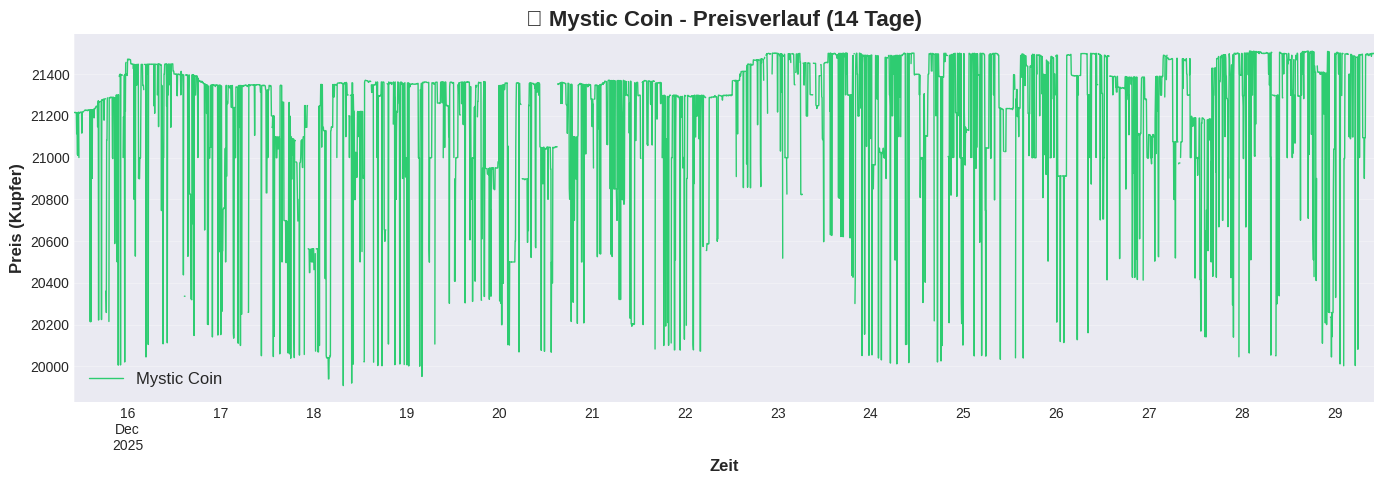

In [13]:
# Plot: Komplette Zeitreihe
fig, ax = plt.subplots(figsize=(14, 5))
data.series.plot(ax=ax, label=data.item_name, color=COLORS['train'], linewidth=1)
ax.set_title(f'📈 {data.item_name} - Preisverlauf ({DAYS_BACK} Tage)', fontsize=16, fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis (Kupfer)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2. ✂️ Train/Test Split


In [14]:
# Split
train, test = data.split(train=TRAIN_RATIO)
print(f"Train: {len(train)} Datenpunkte ({len(train)/288:.1f} Tage)")
print(f"Test:  {len(test)} Datenpunkte ({len(test)/288:.1f} Tage)")


Train: 3225 Datenpunkte (11.2 Tage)
Test:  807 Datenpunkte (2.8 Tage)


## 3. 🎓 Exponential Smoothing Modelle trainieren


In [15]:
# Verschiedene ES Konfigurationen
configs = [
    {"name": "Simple ES", "trend": None, "damped": False},
    {"name": "Holt (Trend)", "trend": "add", "damped": False},
    {"name": "Damped Holt", "trend": "add", "damped": True},
]

models = {}
forecasts = {}

print("🎓 Trainiere Exponential Smoothing Modelle...\n")

for config in configs:
    name = config.pop("name")
    print(f"   🔄 {name}...")
    
    model = ExponentialSmoothingModel(**config)
    model.fit(train)
    forecast = model.predict(n=len(test))
    
    models[name] = model
    forecasts[name] = forecast
    print(f"      ✅ {model}")

print("\n✅ Alle Modelle trainiert!")


🎓 Trainiere Exponential Smoothing Modelle...

   🔄 Simple ES...
      ✅ ETS(A,N,N)
   🔄 Holt (Trend)...
      ✅ ETS(A,A,N)
   🔄 Damped Holt...
      ✅ ETS(A,Ad,N)

✅ Alle Modelle trainiert!


## 4. 📊 Forecast vs. Actual


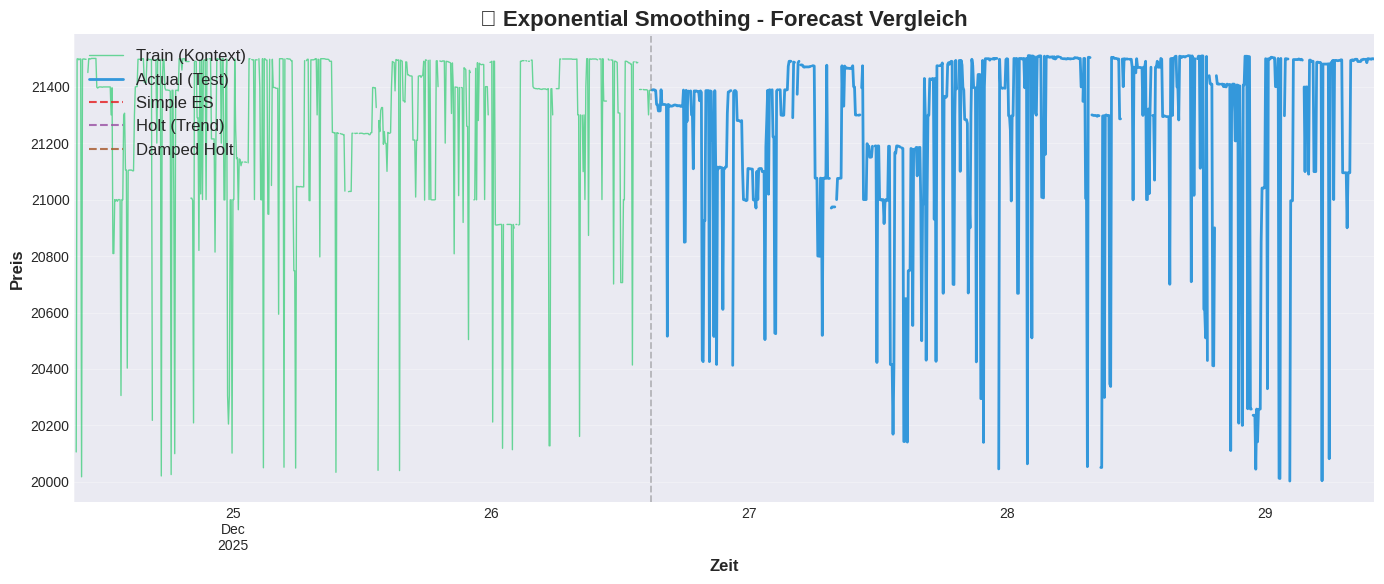

In [16]:
# Plot: Alle Forecasts im Vergleich
fig, ax = plt.subplots(figsize=(14, 6))

# Train Kontext
train_context = train[-int(len(train)*0.2):]
train_context.plot(ax=ax, label='Train (Kontext)', color=COLORS['train'], linewidth=1, alpha=0.7)

# Actual (Test)
test.plot(ax=ax, label='Actual (Test)', color=COLORS['test'], linewidth=2)

# Forecasts
cmap = plt.cm.Set1
for i, (name, forecast) in enumerate(forecasts.items()):
    c = cmap(i / len(forecasts))
    forecast.plot(ax=ax, label=f'{name}', color=c, linewidth=1.5, linestyle='--', alpha=0.8)

ax.set_title(f'🔮 Exponential Smoothing - Forecast Vergleich', fontsize=16, fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.axvline(x=train.end_time(), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [17]:
# Metriken berechnen
def calc_metrics(actual, forecast):
    """Berechne Metriken manuell (robuster bei NaN)."""
    act = actual.values().flatten()
    fc = forecast.values().flatten()
    min_len = min(len(act), len(fc))
    act, fc = act[:min_len], fc[:min_len]
    
    # Ersetze NaN durch 0 für Berechnung
    if np.any(np.isnan(fc)):
        return {"mape": np.nan, "rmse": np.nan, "mae": np.nan, "has_nan": True}
    
    mape = np.mean(np.abs((act - fc) / act)) * 100
    rmse = np.sqrt(np.mean((act - fc) ** 2))
    mae = np.mean(np.abs(act - fc))
    return {"mape": mape, "rmse": rmse, "mae": mae, "has_nan": False}

# Berechne für alle Modelle
results = []
for name, forecast in forecasts.items():
    metrics = calc_metrics(test, forecast)
    results.append({
        "Modell": name,
        "ETS Notation": str(models[name]),
        **metrics
    })

results_df = pd.DataFrame(results)
print("📊 Performance Vergleich:\n")
print(results_df.to_string(index=False))


📊 Performance Vergleich:

      Modell ETS Notation  mape  rmse  mae  has_nan
   Simple ES   ETS(A,N,N)   NaN   NaN  NaN     True
Holt (Trend)   ETS(A,A,N)   NaN   NaN  NaN     True
 Damped Holt  ETS(A,Ad,N)   NaN   NaN  NaN     True


## 5. 🔄 Vergleich mit ARIMA


In [18]:
# ARIMA zum Vergleich
print("🎓 Trainiere ARIMA zum Vergleich...")
arima = ARIMAModel(p=1, d=1, q=1)
arima.fit(train)
arima_forecast = arima.predict(n=len(test))
print(f"✅ {arima}")

# Metriken
arima_metrics = calc_metrics(test, arima_forecast)
print(f"\n📊 ARIMA Metriken:")
print(f"   MAPE: {arima_metrics['mape']:.2f}%")
print(f"   RMSE: {arima_metrics['rmse']:.2f}")
print(f"   MAE:  {arima_metrics['mae']:.2f}")


🎓 Trainiere ARIMA zum Vergleich...
✅ ARIMA(1,1,1)

📊 ARIMA Metriken:
   MAPE: nan%
   RMSE: nan
   MAE:  nan


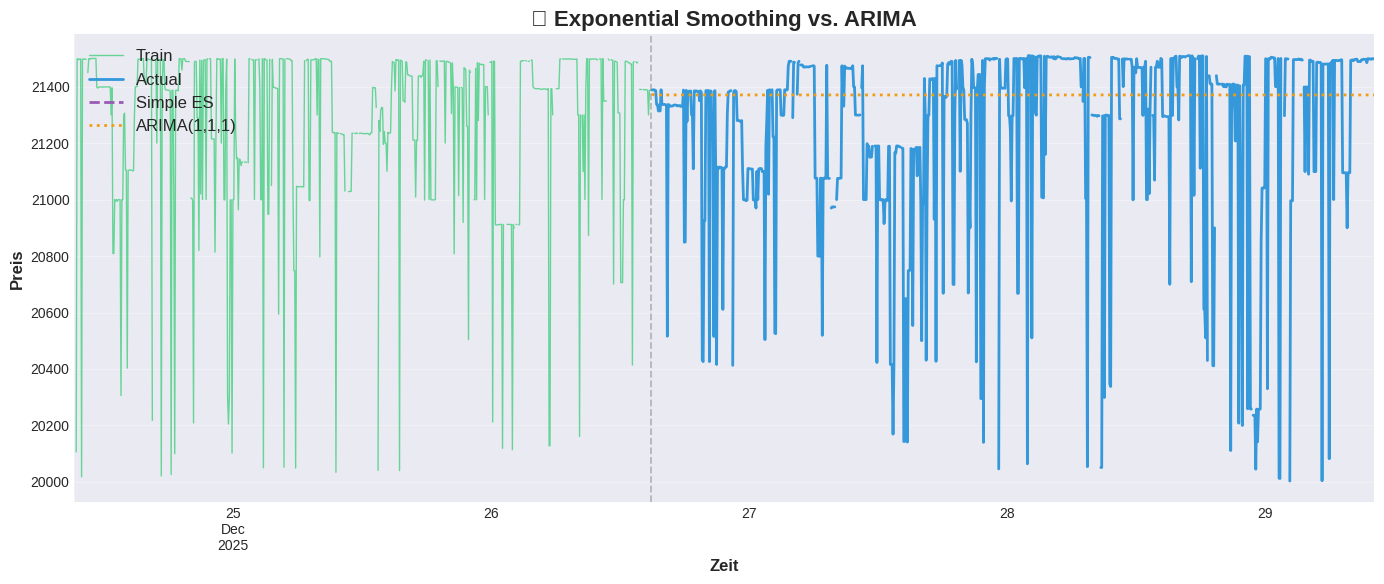

In [19]:
# Plot: ES vs ARIMA
fig, ax = plt.subplots(figsize=(14, 6))

# Train Kontext
train_context = train[-int(len(train)*0.2):]
train_context.plot(ax=ax, label='Train', color=COLORS['train'], linewidth=1, alpha=0.7)

# Actual
test.plot(ax=ax, label='Actual', color=COLORS['test'], linewidth=2)

# Bestes ES Modell (Simple ES)
forecasts['Simple ES'].plot(ax=ax, label='Simple ES', color=COLORS['es'], linewidth=2, linestyle='--')

# ARIMA
arima_forecast.plot(ax=ax, label='ARIMA(1,1,1)', color=COLORS['arima'], linewidth=2, linestyle=':')

ax.set_title(f'📊 Exponential Smoothing vs. ARIMA', fontsize=16, fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.axvline(x=train.end_time(), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## 6. 📈 Zusammenfassung & Erkenntnisse


In [20]:
# Zusammenfassung
print("=" * 60)
print("📈 ZUSAMMENFASSUNG")
print("=" * 60)
print(f"\n🎯 Item: {data.item_name} (ID: {data.item_id})")
print(f"📅 Zeitraum: {data.start_time.strftime('%Y-%m-%d')} bis {data.end_time.strftime('%Y-%m-%d')}")
print(f"📊 Datenpunkte: {data.num_points} ({data.total_days:.1f} Tage)")

print("\n" + "-" * 60)
print("🔮 EXPONENTIAL SMOOTHING:")
print("-" * 60)
for _, row in results_df.iterrows():
    if not row['has_nan']:
        print(f"   {row['Modell']:20} MAPE: {row['mape']:.2f}%")
    else:
        print(f"   {row['Modell']:20} (NaN - nicht konvergiert)")

print("\n" + "-" * 60)
print("📊 ARIMA:")
print("-" * 60)
if not arima_metrics['has_nan']:
    print(f"   ARIMA(1,1,1)          MAPE: {arima_metrics['mape']:.2f}%")
else:
    print(f"   ARIMA(1,1,1)          (NaN)")

print("\n" + "=" * 60)
print("💡 ERKENNTNISSE:")
print("=" * 60)
print("""
1. Exponential Smoothing und ARIMA produzieren ähnliche Ergebnisse
   bei volatilen Preisdaten (oft flache Linien).

2. Diese klassischen Modelle sind für "Random Walk"-Daten nicht ideal:
   - Sie erkennen keine komplexen Muster
   - Sie extrapolieren hauptsächlich den Durchschnitt/letzten Wert

3. Empfehlung für bessere Forecasts:
   - Machine Learning Modelle (XGBoost, LightGBM)
   - Deep Learning (N-BEATS, TFT)
   - Feature Engineering (Lag Features, Rolling Stats)
""")


📈 ZUSAMMENFASSUNG

🎯 Item: Mystic Coin (ID: 19976)
📅 Zeitraum: 2025-12-15 bis 2025-12-29
📊 Datenpunkte: 4032 (14.0 Tage)

------------------------------------------------------------
🔮 EXPONENTIAL SMOOTHING:
------------------------------------------------------------
   Simple ES            (NaN - nicht konvergiert)
   Holt (Trend)         (NaN - nicht konvergiert)
   Damped Holt          (NaN - nicht konvergiert)

------------------------------------------------------------
📊 ARIMA:
------------------------------------------------------------
   ARIMA(1,1,1)          MAPE: nan%

💡 ERKENNTNISSE:

1. Exponential Smoothing und ARIMA produzieren ähnliche Ergebnisse
   bei volatilen Preisdaten (oft flache Linien).

2. Diese klassischen Modelle sind für "Random Walk"-Daten nicht ideal:
   - Sie erkennen keine komplexen Muster
   - Sie extrapolieren hauptsächlich den Durchschnitt/letzten Wert

3. Empfehlung für bessere Forecasts:
   - Machine Learning Modelle (XGBoost, LightGBM)
   - Deep L